# Tigramite methods on multiple datasets of time series

This notebook explains the multiple datasets functionality for [TIGRAMITE](https://github.com/jakobrunge/tigramite), which allows to run causal discovery methods such as PCMCI and PCMCI$^+$ or also the CausalEffect class tools on multiple datasets of time series. Here we focus on the PCMCI/PCMCI$^+$ functionality and refer to this as Multidata-PCMCI in short. Familiarity with the basic usage of PCMCI or PCMCI$^+$ is assumed.

## Overview

In short, Multidata-PCMCI implements two functionalities that distinguish it from standard PCMCI (and PCMCI$^+$). These are:
- It operates on not just a single time series(*) but rather on a collection of several, i.e., on multiple arrays of time series. The samples for conditional independence testing are created from all datasets.
- It allows to specify which time steps are used to create samples for conditional independence testing. This specification is not required, per default the method creates as many samples as possible.

To see how Multidata-PCMCI is used in practice, jump to the next section (titled *Usage*). To learn more about the distinction of PCMCI and Multidata-PCMCI and on the new functionalities provided by Multidata-PCMCI, keep on reading here.

(*) A single time series may be and typically is multivariate, i.e., has multiple component time series.

#### Details

The standard PCMCI algorithm operates on a single time series. That is to say, the data are an array of shape $(T, N)$ where $T$ is the number of time steps and $N$ the number of variables ($=$ the number of component time series). When the algorithm performs a statistical test of the conditional independence $X_{t-\tau_i} \perp\!\!\!\perp Y_t | Z_{t-\tau_k}$, where $X$, $Y$ and $Z$ are any three of the $N$ variables and $\tau_i \geq 0$ and $\tau_k \geq 0$ are time lags, the samples for this test are created from the different time steps of the time series data. This is justified by the assumption of stationarity.

To be more precise, the samples for this test will be $(X_{s-\tau_i}, Y_{s}, Z_{s-\tau_k})$ for $s$ in the range $s = 2 \tau_{\text{max}}, 2 \tau_{\text{max}} + 1, \ldots, T - 1$ (starting to count at $0$, so that the latest time step is $T-1$). Here, $\tau_{\text{max}}$ is the maximal considered time lag which means that $\tau_i$ and $\tau_k$ are restricted to $\tau_i \leq \tau_{\text{max}}$ and $\tau_k \leq \tau_{\text{max}}$. This justifies that the first $\tau_{\text{max}}$ time steps must be disregarded, corresponding to the restriction $s \geq \tau_{\text{max}}$, because else some of the subscripts in $(X_{s-\tau_i}, Y_{s}, Z_{s-\tau_k})$ may be negative and thus be out of bounds. The reason for the stronger restriction $s \geq 2\tau_{\text{max}}$ lies in the design of PCMCI, the details of which are not important here.

In practice, however, one might have access to not just a single but rather multiple time series corresponding to the same process. Put differently, one might have $M$ arrays of shape $(T^{(m)}, N)$ each of which is a realization of the same process. In testing for conditional independencies one may then combine the samples taken from these $M$ datasets and learn a *single* causal graph for the shared underlying process. The datasets are indexed by the superscript $m$ with $0 \leq m \leq M-1$ and are not required to have the same time length, i.e., $T^{(m)}$ may depend on $m$.

By default the underlying process is assumed to be stationary. It is then not necessary to specify which time step of dataset $m_0$ corresponds to which time step of dataset $m_1$, because all samples anyway belong to the same distribution. However, the sampling interval must be the same for all $M$ datasets. The samples for testing $X_{t-\tau_i} \perp\!\!\!\perp Y_t | Z_{t-\tau_k}$ thus are $(X^{(m)}_{s-\tau_i}, Y^{(m)}_{s}, Z^{(m)}_{s-\tau_k})$ with $s = 2 \tau_{\text{max}}, 2 \tau_{\text{max}} + 1, \ldots, T^{(m)} - 1$ for $0 \leq m \leq M-1$. This is the key functionality implemented by Multidata-PCMCI (cf. the first bullet point in above list).

Multidata-PCMCI also encompasses the functionality to run analyses that take potential non-stationarities into account. It then becomes necessary to carefully specify which time steps of which dataset are to be combined and used for conditional independence testing (cf. the second bullet point in above list). This requires two pieces of information:
1. First, it becomes necessary to align the individual datasets in time, i.e., to specify which time step of dataset $m_0$ corresponds to which time step of dataset $m_1$. In other words, the invidual dataset time series need to be aligned on a common time axis. For example, the datasets may be the measured neural activities in different subjects that are exposed to a certain stimulus. It is then necessary to specify at which time steps $T^{(m)} = t^{(m)}$ the stimulus was given for the individual subjects. By default the datasets are aligned at the $0$-the time step. This can be modified by the `time_offsets` keyword argument.
2. Second, it becomes necessary to specify which time steps of the aligned time axis are used to create samples. Continuing with the previous example, one may want to restrict attention to the first minute after giving the stimulus or to separately analyze the first vs. second minute after giving the stimulus. As another example, in environmental time series one may separately analyze summer and winter months. By default as many samples as possible are created, i.e., all time steps but the $2\tau_{\text{max}}$ first time steps of each dataset time series are used. This can be modified by the `reference_points` keyword argument.

## Usage

This section explains the practical use of Multidata-PCMCI. It is split in five parts:
1. Basic use and commands.
2. Example.
3. The `reference_points` keyword argument.
4. The `time_offsets` keyword argument.
5. Further comments.

### 1. Basic use and commands

Multidata-PCMCI is implemented in the current TIGRAMITE classes `PCMCI` and `DataFrame`. **Note, however, that Multidata-PCMCI does NOT yet work with the `Prediction` class.**

Multidata-PCMCI expects the data in one of two formats:
1. A 3D numpy array of shape $(M, T, N)$. Here, the first dimension corresponds to the individual datasets, the second to the time steps, and the third to the variables. This requires all datasets to have the same time length and the `time_offsets` functionality must not be used, i.e., `time_offsets` must be `None`.
2. A dictionary whose values are 2D numpy arrays of the shape $(T^{(m)}, N)$ , where the time lengths $T^{(m)}$ may vary across the entries but the number of variables $N$ must be the same for all entries.

Examples of how to instantiate a `DataFrame` object for using Multidata-PCMCI:

In [1]:
## Option 1: Data is a 3D numpy array
# data = np.random.randn(8, 100, 5)
# dataframe = DataFrame(data, analysis_mode = 'multiple')

## Option 2: Data is a dictionary of 2D numpy arrays
# time_lengths = [100, 105, 92, 103, 90]
# data = {m: np.random.randn(T, 5) for m, T in enumerate(time_lengths)}
# dataframe = DataFrame(data, analysis_mode = 'multiple')

The key here is the specification of the keyword argument `analysis_mode` as `analysis_mode = 'multiple'`, which tells the `DataFrame` class that it will be used to run Multidata-PCMCI instead of standard PCMCI. If unspecified, `analysis_mode` defaults to `analysis_mode = 'single'`, which corresponds to standard PCMCI.

In `analysis_mode = 'single'`, the `data` argument can be given as a 2D numpy array of shape $(T, N)$ or a as dictionary whose single entry is a 2D numpy array of shape $(T, N)$.

From here on everything works as usual: You have already specified to use Multidata-PCMCI instead of PCMCI when constructing the `DataFrame` object and there is no need to specify this once more when constructing or using a `PCMCI` object. Therefore, you might for example do the following:

In [2]:
# from tigramite.independence_tests import ParCorr
# pcmci = PCMCI(dataframe = dataframe, cond_ind_test = ParCorr())
# results = pcmci.run_pcmci(tau_max = 2, pc_alpha = 0.05)

### 2. Example

In [3]:
import numpy as np
np.random.seed(42)

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from tigramite.independence_tests import ParCorr

from tigramite.data_processing import DataFrame
from tigramite.pcmci import PCMCI
import tigramite.plotting as tp

**Data generation:** For the purpose of illustration we here generate artificial data, namely several realizations  of, i.e., multiple instances from a linear VAR process of order 1 with standard normal noise.

In [4]:
## Option 1: Data is 3D numpy array

M = 5 # number of datasets
T = 60 # number of time steps
N = 3 # number of variables

data = np.random.randn(M, T, N)
for t in range(1, T):
    data[:, t, 0] += 0.7*data[:, t-1, 0] 
    data[:, t, 1] += 0.6*data[:, t-1, 1] + 0.6*data[:, t-1, 0]
    data[:, t, 2] += 0.5*data[:, t-1, 2] - 0.6*data[:, t-1, 1]

In [5]:
## Option 2: Data is dictionary of 2D numpy arrays

M = 5 # number of datasets
T = [40, 50, 60, 70, 80] # number of time steps for the individual datasets
N = 3 # number of variables

data = {i: np.random.randn(T[i], N) for i in range(M)}
for i in range(M):
    for t in range(1, T[i]):
        data[i][t, 0] += 0.7*data[i][t-1, 0] 
        data[i][t, 1] += 0.6*data[i][t-1, 1] + 0.6*data[i][t-1, 0]
        data[i][t, 2] += 0.5*data[i][t-1, 2] - 0.6*data[i][t-1, 1]

**Instantiation of the `DataFrame` object:** Create a `DataFrame` object as explained above. Note that setting the variable names by means of the keyword argument `var_names` is optional, we here choose to do this in order to have a more informative graphical visualization below.

In [6]:
var_names = [r'$X^0$', r'$X^1$', r'$X^2$']
dataframe = DataFrame(data, analysis_mode = 'multiple', var_names = var_names)

**Plotting of time series:** To plot the individual dataset time series, use the `plot_timeseries()` and specify the desired dataset by the argument `selected_dataset`.

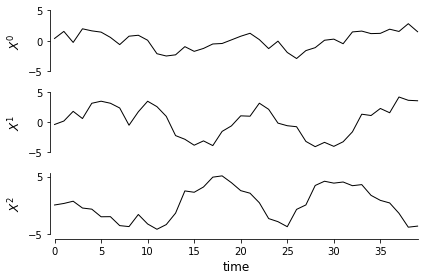

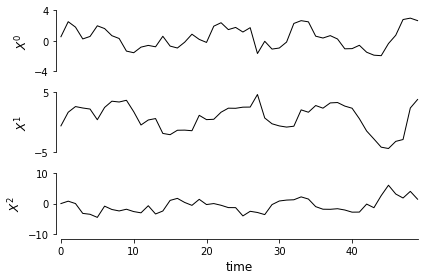

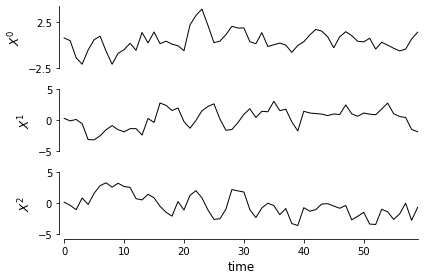

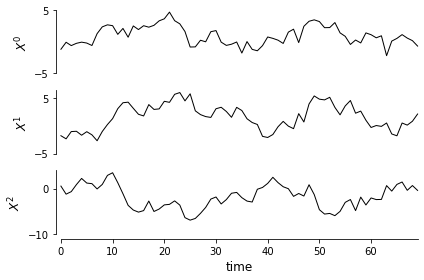

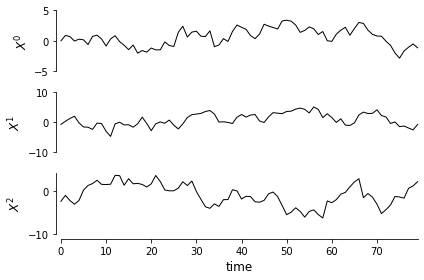

In [7]:
for member in dataframe.values.keys():
    tp.plot_timeseries(selected_dataset = member, dataframe = dataframe)
    plt.show()

**Running Multidata-PCMCI:** To run Multidata-PCMCI, create and apply a `PCMCI` object in the same way as you would do for standard PCMCI. The information that Multidata-PCMCI rather than standard PCMCI is to be used has already been specified upon instantiation of the `DataFrame` object. For the purpose of illustration we here also graphically illustrate the results. **You may also run PCMCI instead of PCMCI$^+$.

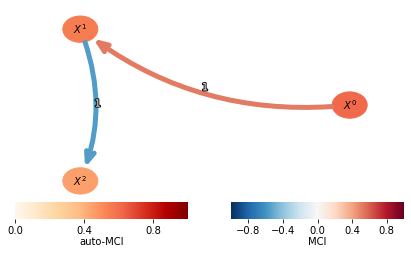

In [8]:
pcmci = PCMCI(dataframe = dataframe, cond_ind_test = ParCorr())
results = pcmci.run_pcmciplus(tau_max = 2, pc_alpha = 0.01)

tp.plot_graph(graph=results['graph'], val_matrix=results['val_matrix'], var_names=var_names)
plt.show()

### 3. The `reference_points` keyword argument

The specification of the time steps to be used for creating samples for conditional independence testing too happens in the instantiation of the `DataFrame` object. This is done by the optional keyword argument `reference_points`. It works as follows, for an example see further below. We here assume that `time_offsets` is `None`, such that the individual dataset time series are aligned at the $0$-th time step.
- To specify that, say, only the first hundred time steps are to be considered, pass the list `[0, 1, ..., 98,  99]` or, equivalently, the numpy array `np.array([0, 1, ..., 98,  99])` to the `reference_points` keyword argument.
- To specify that only the single time step $t_0$ is to be used, pass the list `[t_0]` or, equivalently, the integer `t_0`.
- If unspecified, `reference_points` defaults to `None`. This is equivalent to passing `[0, 1, ..., T^{\text{max}} - 1]`, where $T^{\text{max}} = \operatorname{max}_{0 \leq m \leq M-1} T^{(m)}$ is the number of time steps in the longest dataset time series. Thus, as many samples as possible are taken.
- All specified time steps that are smaller than $0$ or larger than $T^{\text{max}}- 1$ are automatically disregarded. At least one of the specified time steps must be within $\{0, 1, \ldots, T^{\text{max}} - 1\}$.

- The passed list is not required to correspond to an interval. For example, you might also specify to use every second time step by passing `[0, 2, 4, ...]`.
- In all cases, the first $s\geq 2 \tau_{\text{max}}$ time steps are disregarded automatically when `PCMCI.run_pcmci()` or `PCMCI.run_pcmciplus()` are executed.

Below, we consider an example in which the causal graphs changes within the duration of the time series. In particular: a certain causal link first weakens in strength, then changes its direction and grows again in strength. While this could also be handled by the masking functionality, the example serves to illustrate one use case of the `reference_points` keyword: It allows to specify time windows to be considered and thereby allows to analyze whether and how the causal graph changes in time.

In [9]:
T = [100, 120, 150, 200, 110, 180, 190, 77] # number of time steps of the individual datasets
M = len(T) # number of datasets
N = 3 # number of variables

var_names = [r'$X^0$', r'$X^1$',  r'$X^2$']

data = {i: np.random.randn(T[i], N) for i in range(M)}

for i in range(M):
    for t in range(1, min(40, T[i])):
        data[i][t, 0] += 0.7*data[i][t-1, 0] 
        data[i][t, 1] += 0.6*data[i][t-1, 1] + 0.6*data[i][t-1, 0]
        data[i][t, 2] += 0.5*data[i][t-1, 2] - 0.6*data[i][t-1, 1]
        
    for t in range(40, min(80, T[i])):
        data[i][t, 0] += 0.7*data[i][t-1, 0] 
        data[i][t, 1] += 0.6*data[i][t-1, 1] + 0.3*data[i][t-1, 0]
        data[i][t, 2] += 0.5*data[i][t-1, 2] - 0.6*data[i][t-1, 1]
        
    for t in range(80, min(120, T[i])):
        data[i][t, 0] += 0.7*data[i][t-1, 0] 
        data[i][t, 1] += 0.6*data[i][t-1, 1]
        data[i][t, 2] += 0.5*data[i][t-1, 2] - 0.6*data[i][t-1, 1]
        
    for t in range(120, min(160, T[i])):
        data[i][t, 0] += 0.7*data[i][t-1, 0] + 0.3*data[i][t-1, 1]
        data[i][t, 1] += 0.6*data[i][t-1, 1] 
        data[i][t, 2] += 0.5*data[i][t-1, 2] - 0.6*data[i][t-1, 1]
        
    for t in range(160, min(200, T[i])):
        data[i][t, 0] += 0.7*data[i][t-1, 0] + 0.6*data[i][t-1, 1]
        data[i][t, 1] += 0.6*data[i][t-1, 1] 
        data[i][t, 2] += 0.5*data[i][t-1, 2] - 0.6*data[i][t-1, 1]

In [10]:
def run_and_plot(dataframe, cond_ind_test):
    
    # Create and run Multidata-PCMCIplus
    pcmci = PCMCI(dataframe = dataframe, cond_ind_test = cond_ind_test)
    results = pcmci.run_pcmciplus(tau_max = 2, pc_alpha = 0.01)
    
    tp.plot_graph(graph=results['graph'], val_matrix=results['val_matrix'], var_names=var_names)
    plt.show()

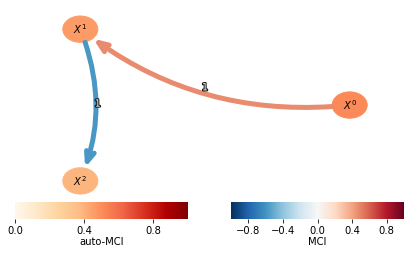

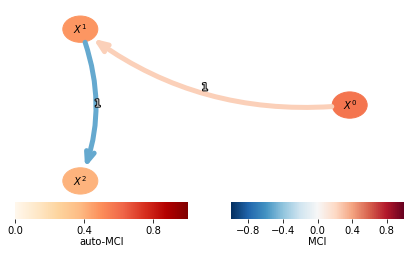

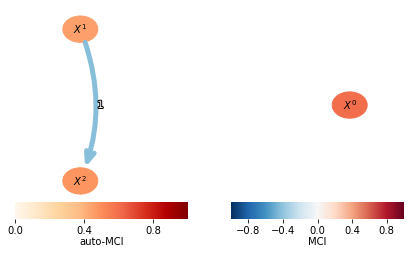

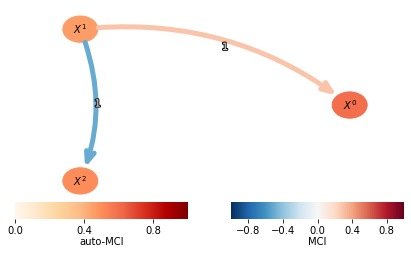

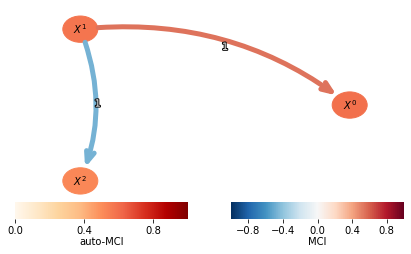

In [11]:
# Run through the five regimes (which we here assume to be known)
for i in range(5):
    # Define the respective time steps and accordingly create the DataFrame object
    # by using the 'reference_points' keyword
    reference_points = list(range(i*40, (i+1)*40))
    dataframe = DataFrame(data,
                          analysis_mode = 'multiple',
                          reference_points = reference_points,
                          var_names = var_names
                         )
    # Run Multidata-PCMCIplus and plot the results
    run_and_plot(dataframe = dataframe, cond_ind_test = ParCorr())

### 4. The `time_offsets` keyword argument.

Also the alignment of the individual dataset time series on a shared time axis happens in the instantiation of the `DataFrame` object. This is done by means of the optional keyword argument `time_offsets`. It works as follows, for an example see further below.
- The use of `time_offsets` requires that, first, `analysis_mode = 'multiple'` and that, second, the `data` argument is given as a dictionary rather than a 3D numpy array. Else `None` must be passed, which is also the default.
- `time_offsets` expects a dictionary of the form `{key(m_0): time_offset(m_0), key(m_1): time_offset(m_1), ...}`.
- The set of keys of this dictionary must exactly agree with the set of keys of the dictionary passed to `data`.
- Its values must be non-negative integers, at least one of which equals $0$.
- A non-zero time offset `time_offset(m_0)` shifts the corresponding dataset $m_0$ forward in time on the shared time axis by as many time steps.
- For example, consider two datasets $m_0$ and $m_1$. Let `reference_points = [10, 11, 12]` and let `time_offsets = {m_0: 0, m_1: 3}`. Then, for $m_0$ the reference points $10$, $11$, and $12$ correspond to the time indices $10$, $11$, and $12$ while for $m_1$ they correspond to the time indices $7$, $8$, $9$.

Below, we consider an example in which the causal graph of the underlying process changes in time. In particular, after the $100$-th time step the sign of a link reverses. The first dataset is a realization of the first $110$ time steps of this process and the second dataset is a realization of time length $110$ starting at time step $90$. Hence, the $90$-th time index of the first dataset corresponds to the $0$-th time index of the second dataset. We combine the `time_offsets` and `reference_points` keyword arguments to separately analyze the first and second $100$ time steps of the underlying process.

In [12]:
var_names = [r'$X^0$', r'$X^1$',  r'$X^2$']
M = 2
N = 3

data = {i: np.random.randn(200, N) for i in range(M)}
for i in range(M):
    for t in range(1, 100):
        data[i][t, 0] += 0.7*data[i][t-1, 0] 
        data[i][t, 1] += 0.6*data[i][t-1, 1] + 0.6*data[i][t-1, 0]
        data[i][t, 2] += 0.5*data[i][t-1, 2] - 0.6*data[i][t-1, 1]
                
    for t in range(100, 200):
        data[i][t, 0] += 0.7*data[i][t-1, 0]
        data[i][t, 1] += 0.6*data[i][t-1, 1] - 0.6*data[i][t-1, 0]
        data[i][t, 2] += 0.5*data[i][t-1, 2] - 0.6*data[i][t-1, 1]
        
data[0] = data[0][:110, :]
data[1] = data[1][90:, :]

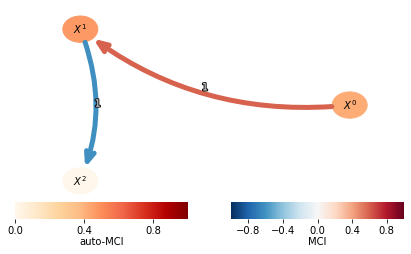

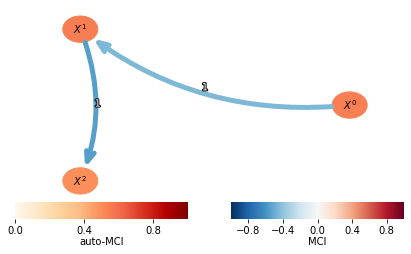

In [13]:
time_offsets = {0: 0, 1: 90}

# First 100 time steps
reference_points = list(range(100))
dataframe = DataFrame(data,
                      analysis_mode = 'multiple',
                      reference_points = reference_points,
                      time_offsets = time_offsets,
                      var_names = var_names)
run_and_plot(dataframe = dataframe, cond_ind_test = ParCorr())

# Second 100 time steps
reference_points = list(range(100, 200))
dataframe = DataFrame(data,
                      analysis_mode = 'multiple',
                      reference_points = reference_points,
                      time_offsets = time_offsets,
                      var_names = var_names)
run_and_plot(dataframe = dataframe, cond_ind_test = ParCorr())

### 5. Futher comments

The functionalities for handling missing values continues to work in the same way as for standard PCMCI.

Also the masking functionality works as usual, with the following qualification: The `mask` must be given in the same format as `data`. For example, if `data` is specified by a dictionary then also `mask` must be specified by a dictionary in the same format.

For more information on missing values and masking please refer to the [respective tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/tigramite_tutorial_missing_masking.ipynb) in the GitHub TIGRAMITE repository.

### 6. Integration into other Tigramite methods

As mentioned in the beginning, the highly modular setup of tigramite implies that you can use the new multiple dataset feature also in other methods of tigramite that are based on the DataFrame class, for example the CausalEffect class to estimate causal effects given causal graphs.

For more information on missing values and masking please refer to the [respective tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/tigramite_tutorial_missing_masking.ipynb) in the GitHub TIGRAMITE repository.